# 0. Import libraries

In [1]:
!pip install pandas -q
!pip install numpy -q
!pip install geopy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import sklearn
from matplotlib import colors
from scipy.stats import zscore

# 1. Load data and fill NaNs

- upload the dataset 
- check which entries are incorrect for some features and then fix or drop the entries (correctness)
- solve the NaN, for each case decide if we fix or drop (completeness)
- finally we can obtein the clean dataset, with which we can start to work and analyse it in step 2

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
poi_df = pd.read_csv('data/poi.csv')

/tmp/ipykernel_12721/4245473066.py:3: DtypeWarning: Columns (7,9,11,13,17,18,19,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,74,77,80,82,83,84,85,86,87,90,91,92,95) have mixed types. Specify dtype option on import or set low_memory=False.
  poi_df = pd.read_csv('data/poi.csv')


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46312 entries, 0 to 46311
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46312 non-null  int64  
 1   price                46312 non-null  int64  
 2   balcony              30869 non-null  object 
 3   conditions           45083 non-null  object 
 4   construction_year    32366 non-null  float64
 5   latitude             46299 non-null  float64
 6   longitude            46299 non-null  float64
 7   energy_efficiency    26409 non-null  float64
 8   expenses             30158 non-null  float64
 9   floor                44281 non-null  float64
 10  garden               14783 non-null  object 
 11  n_bathrooms          43896 non-null  float64
 12  elevator             28869 non-null  float64
 13  total_floors         27963 non-null  float64
 14  n_rooms              45959 non-null  float64
 15  proximity_to_center  46299 non-null 

In [5]:
train_df

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461,60000,True,Buono stato / Abitabile,1980.0,41.901300,12.700000,175.00,30.0,2.0,NaN,1.0,NaN,3.0,1.0,1.00000,35.0
1,51304,900000,NaN,Buono stato / Abitabile,NaN,41.907017,12.481311,NaN,NaN,3.0,NaN,1.0,1.0,NaN,3.0,1.00000,131.0
2,33032,33000,NaN,Buono stato / Abitabile,1960.0,41.976500,12.440500,204.20,30.0,4.0,NaN,1.0,NaN,4.0,1.0,1.00000,16.0
3,62281,166000,NaN,Ottimo / Ristrutturato,NaN,45.484800,12.198200,175.00,NaN,1.0,True,1.0,NaN,1.0,2.0,0.99205,100.0
4,45681,410000,True,Buono stato / Abitabile,NaN,45.424480,12.328622,65.91,NaN,3.0,NaN,2.0,1.0,NaN,3.0,1.00000,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085,329999,True,Buono stato / Abitabile,1929.0,41.923500,12.446100,175.00,35.0,3.0,NaN,1.0,NaN,4.0,3.0,1.00000,88.0
46308,17403,599000,True,Da ristrutturare,1920.0,41.916743,12.454925,NaN,170.0,6.0,NaN,2.0,1.0,NaN,5.0,1.00000,189.0
46309,33332,549000,True,Buono stato / Abitabile,NaN,45.454701,9.242711,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,1.00000,140.0
46310,63367,189000,True,Buono stato / Abitabile,1965.0,45.445605,9.245942,NaN,150.0,-1.0,True,1.0,1.0,NaN,3.0,1.00000,70.0


We start by making an anysis of the NaN

In [6]:
def NaN_analysis(df):
    # analysis1: percentage of NaN values in columns
    d = {'column': [], 'n_nan': [], 'percentage': []}
    for col in df.columns:
        n_nan = df[(df[col].isna()) | (df[col].isnull())].shape[0]
        d['column'].append(col)
        d['n_nan'].append(n_nan)
        d['percentage'].append((n_nan*100)/df.shape[0])
    analysis1 = pd.DataFrame(d).sort_values('percentage', ascending=False).reset_index(drop=True)
    # analysis2: number of NaN values in each row grouped by number of NaN values
    d = {'n_nan': [], 'n_rows': []}
    for n_nan in range(1, df.shape[1]+1):
        n_rows = df[df.isna().sum(axis=1) == n_nan].shape[0]
        d['n_nan'].append(n_nan)
        d['n_rows'].append(n_rows)
    analysis2 = pd.DataFrame(d).sort_values('n_nan', ascending=False).reset_index(drop=True)
    return analysis1, analysis2

In [7]:
analysis1, analysis2 = NaN_analysis(train_df)

In [8]:
analysis1

,column,n_nan,percentage
0,garden,31529,68.079547
1,energy_efficiency,19903,42.975903
2,total_floors,18349,39.620401
3,elevator,17443,37.664104
4,expenses,16154,34.880808
5,balcony,15443,33.345569
6,construction_year,13946,30.113146
7,n_bathrooms,2416,5.216790
8,floor,2031,4.385472
9,conditions,1229,2.653740


In [9]:
analysis2

,n_nan,n_rows
0,17,0
1,16,0
2,15,0
3,14,0
4,13,0
5,12,1
6,11,3
7,10,172
8,9,147
9,8,536


In [10]:
def groupby_count_percentage(df, col):
    tmp = df[col].to_frame()
    tmp.fillna('NaN', inplace=True)
    tmp['count'] = 0
    tmp = tmp.groupby(col).count().reset_index().sort_values('count', ascending=False).reset_index(drop=True)
    tmp['percentage'] = (tmp['count']*100)/df.shape[0]
    return tmp

We can notice that for the features balcony and garden the NaN are actually 'False'

In [11]:
groupby_count_percentage(train_df, 'balcony')

,balcony,count,percentage
0,True,30869,66.654431
1,NaN,15443,33.345569


In [12]:
groupby_count_percentage(train_df, 'garden')

,garden,count,percentage
0,NaN,31529,68.079547
1,True,14783,31.920453


In [13]:
train_df['garden'] = train_df['garden'].fillna(False)
train_df['balcony'] = train_df['balcony'].fillna(False)

We encode garden, balcony and condition. In order to have for each feature only int or float as data, in this way we can plot graphs to better understand what to do with the NaN if drop or fix them


In [14]:
train_df['garden'] = train_df['garden'].apply(lambda x: 1 if x == True else 0)
train_df['balcony'] = train_df['balcony'].apply(lambda x: 1 if x == True else 0)

In [15]:
map_conditions = {}
index = 0
for value in train_df['conditions'].unique():
    if value not in map_conditions:
        map_conditions[value] = index
        index += 1
map_conditions

{'Buono stato / Abitabile': 0,
 'Ottimo / Ristrutturato': 1,
 'Da ristrutturare': 2,
 'Nuovo / Nuova costruzione': 3,
 nan: 4}

In [16]:
train_df['conditions'] = train_df['conditions'].apply(lambda x: map_conditions[x])
train_df['conditions'] = train_df['conditions'].apply(lambda x: np.nan if x == map_conditions[np.nan] else x)

For each column that has at keast a NaN as a data we the histogram distribution also in 2D

In [17]:
columns_wnan = []
for col in train_df.columns:
    if train_df[train_df[col].isna()].shape[0] > 0:
        columns_wnan.append(col)
columns_wnan

['conditions',
 'construction_year',
 'latitude',
 'longitude',
 'energy_efficiency',
 'expenses',
 'floor',
 'n_bathrooms',
 'elevator',
 'total_floors',
 'n_rooms',
 'proximity_to_center',
 'surface']

In [18]:
def get_hist(df, feature, min_value=None, max_value=None, b=100):
    df = df.dropna(subset=[feature]).reset_index(drop=True)
    if min_value == None:
        min_value = df[feature].min()
    if max_value == None:
        max_value = df[feature].max()
    tmp = df[df[feature] >= min_value]
    tmp = tmp[tmp[feature] <= max_value]
    plt.hist(tmp.loc[:, feature], bins=b)
    plt.title('histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.ylabel('value')
    plt.xlabel('index')
    plt.show()
    plt.close()
    plt.hist2d(pd.Series(np.array([i for i in range(tmp.loc[:, feature].shape[0])])), tmp.loc[:, feature], bins=b, norm = colors.LogNorm())
    plt.title('2D histogram distribution of {} (min_value: {}, max_value: {}, bins: {})'.format(feature, min_value, max_value, b))
    plt.ylabel('value')
    plt.xlabel('index')
    plt.colorbar()
    plt.show()
    plt.close()
    return

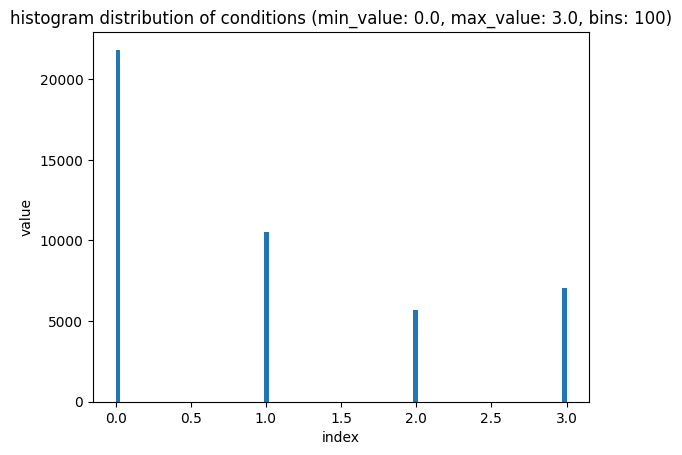

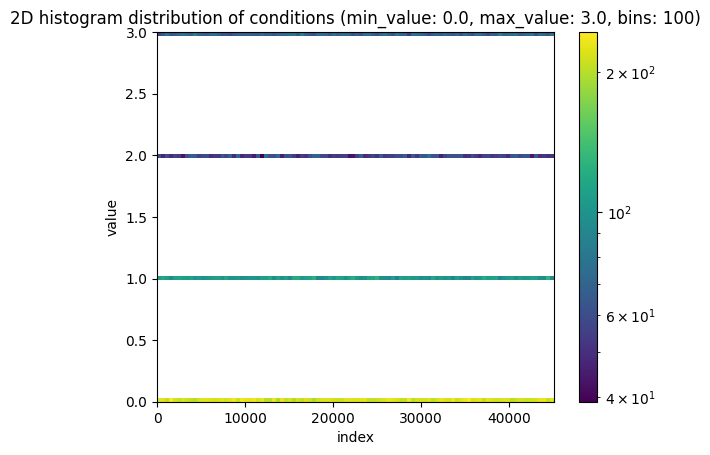

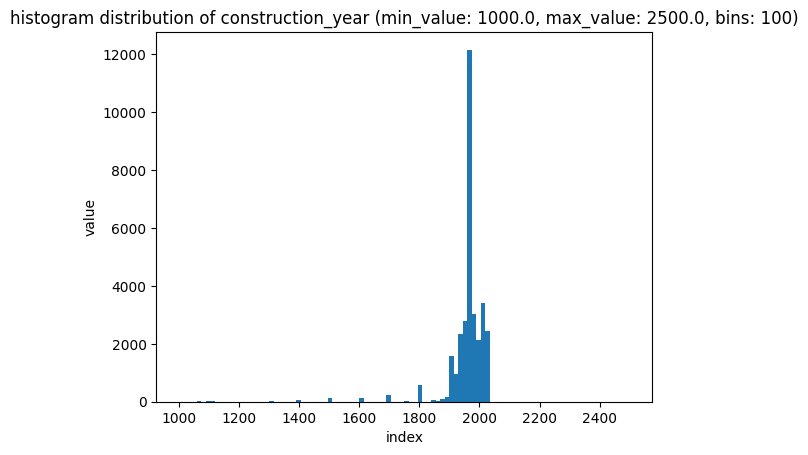

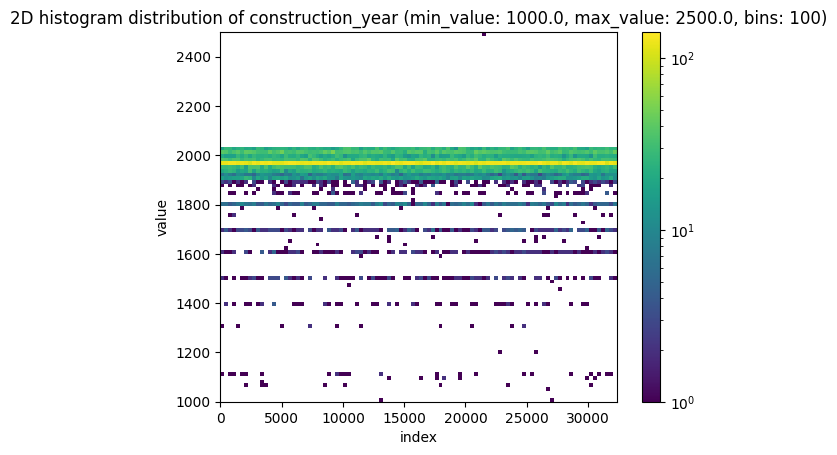

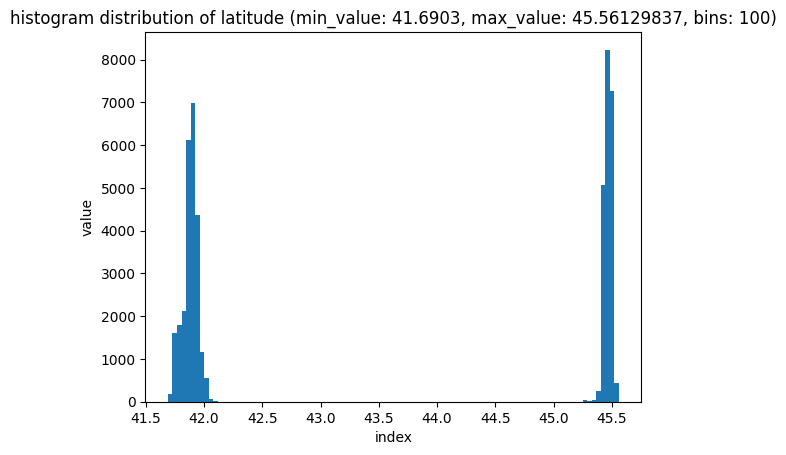

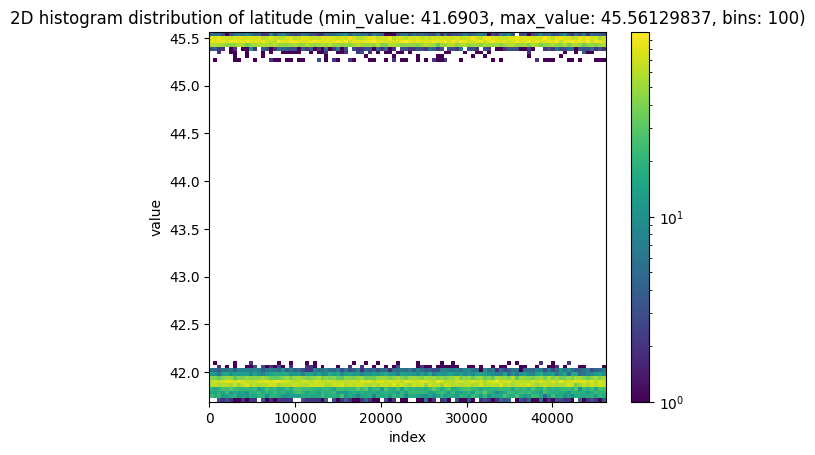

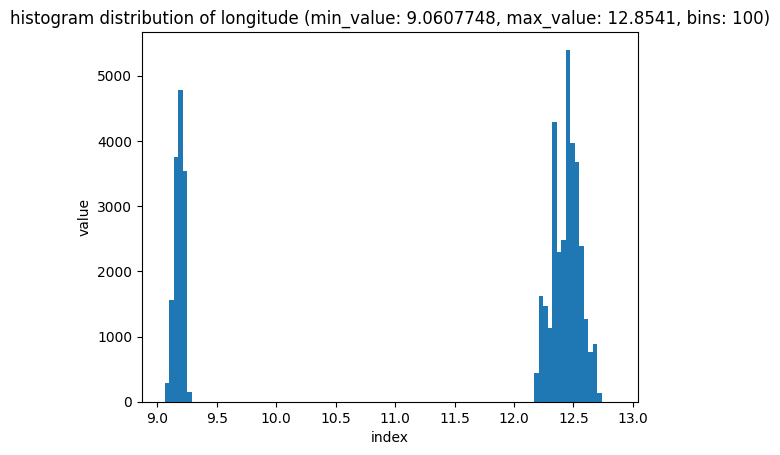

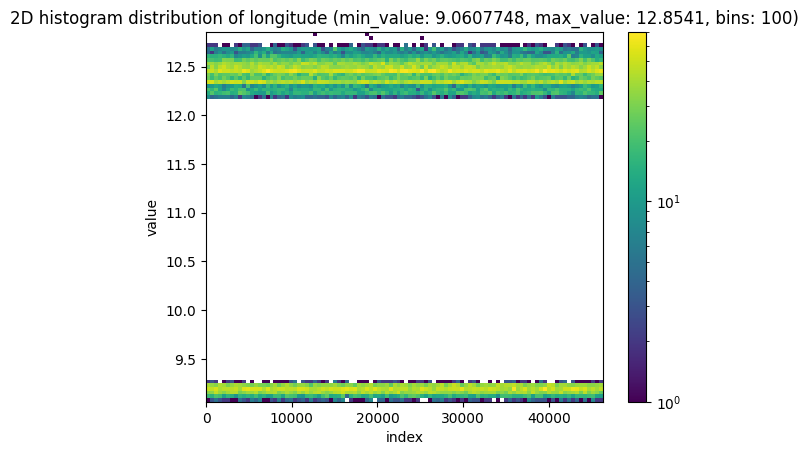

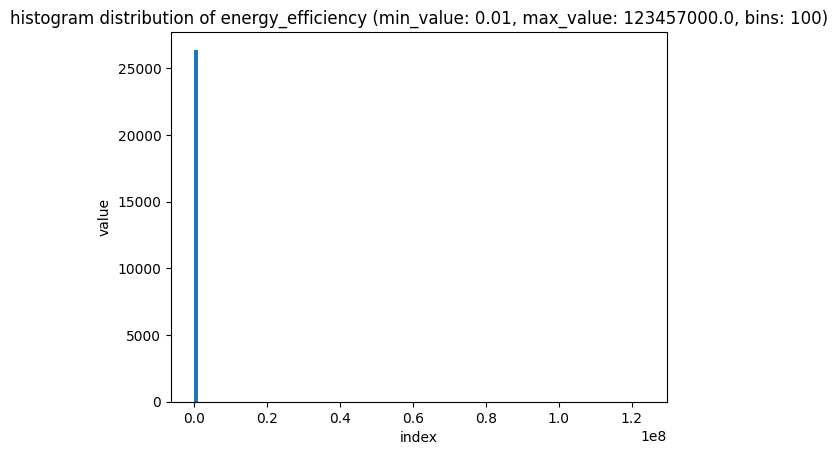

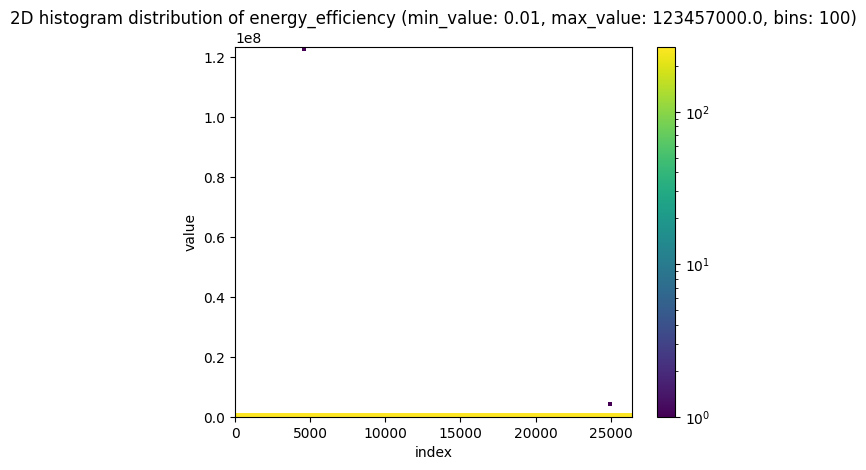

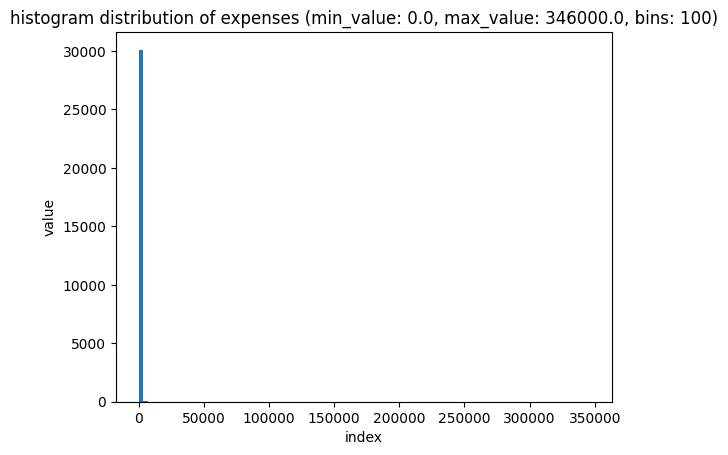

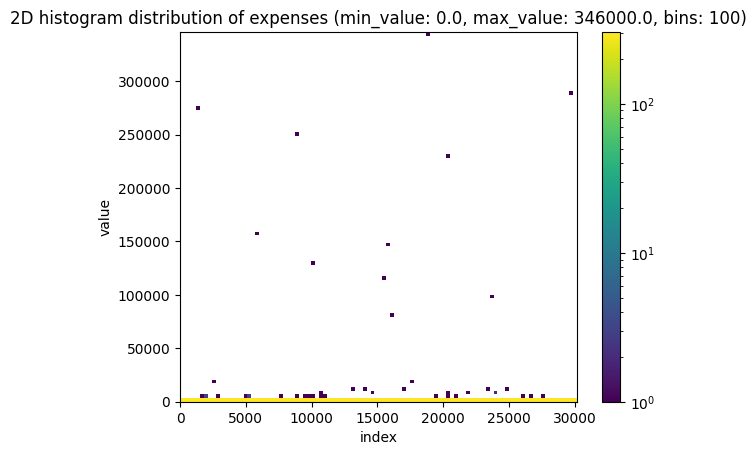

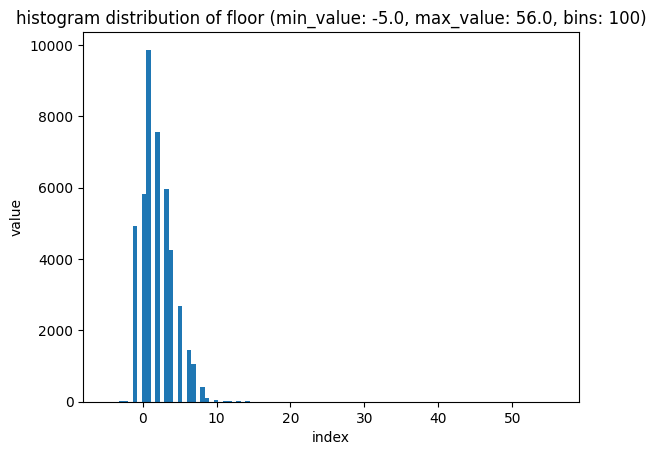

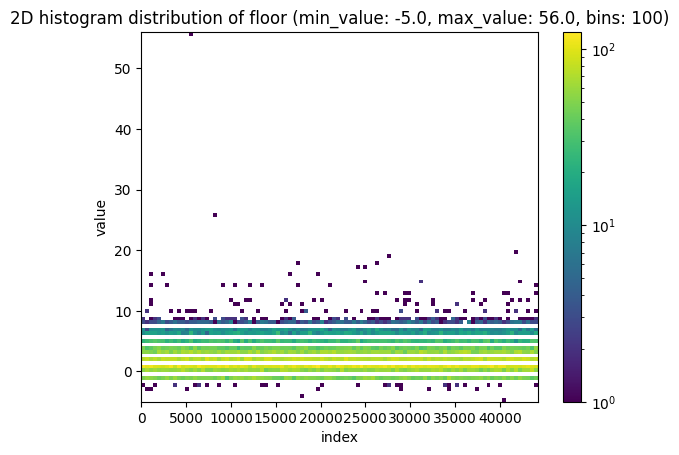

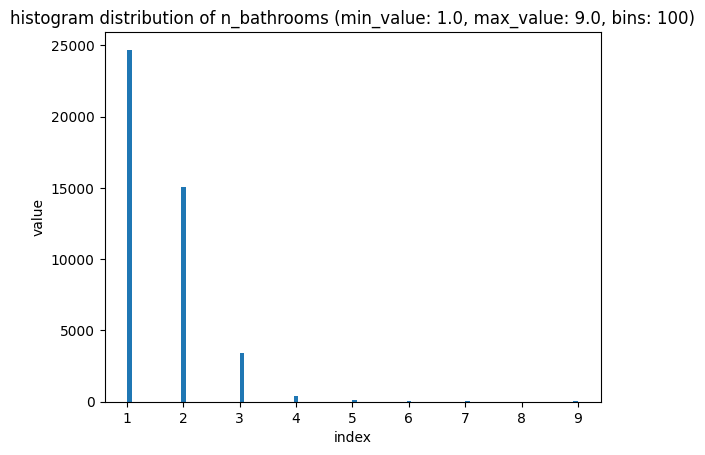

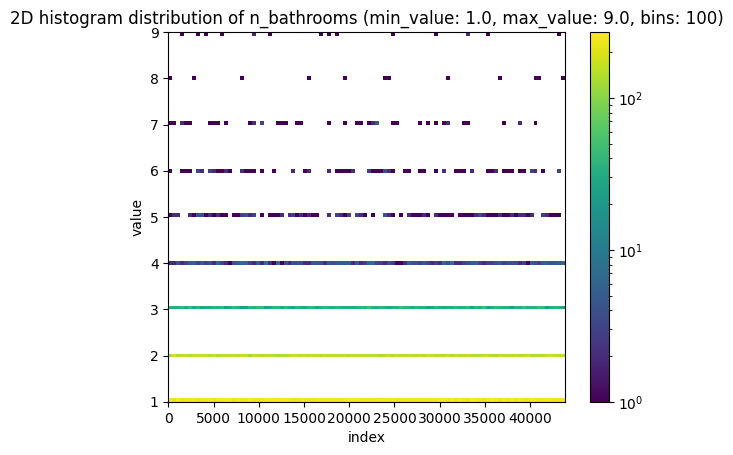

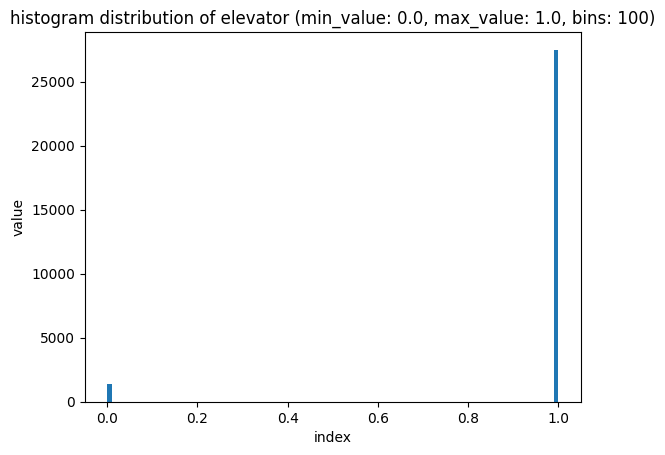

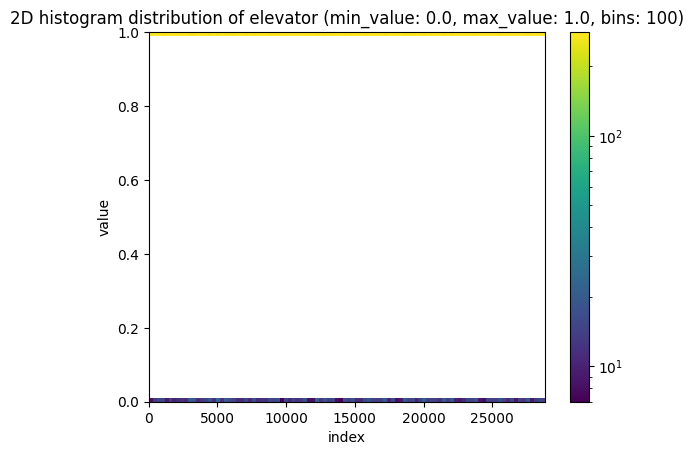

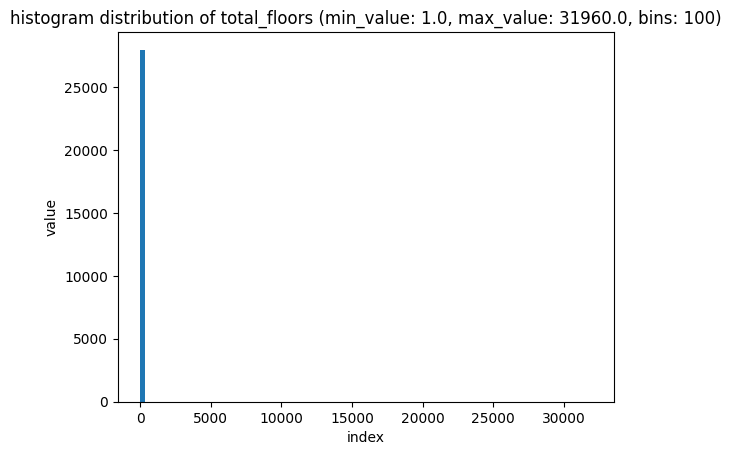

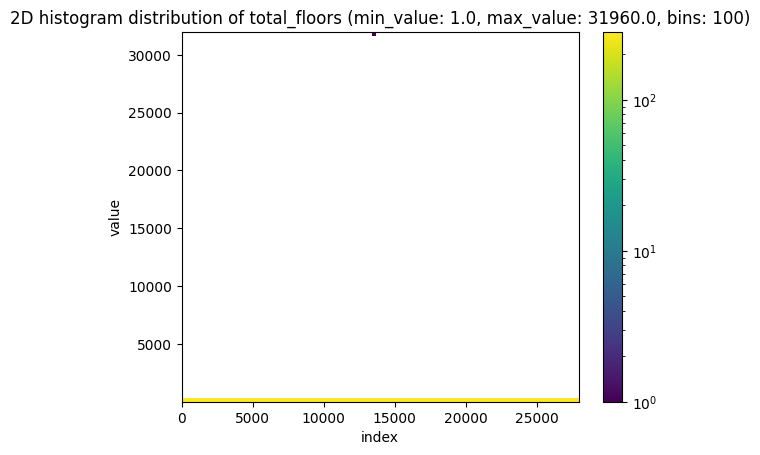

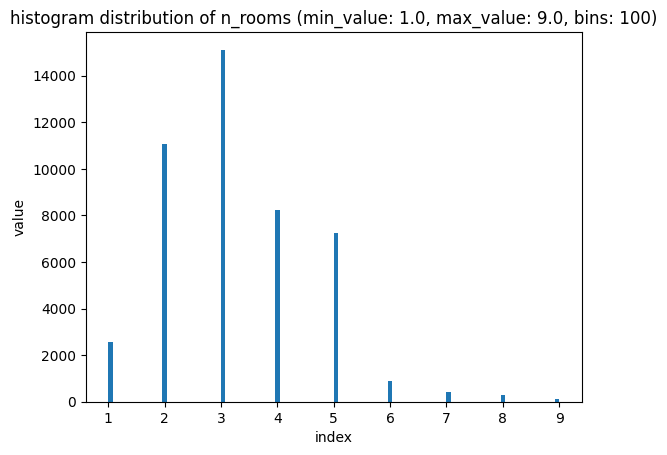

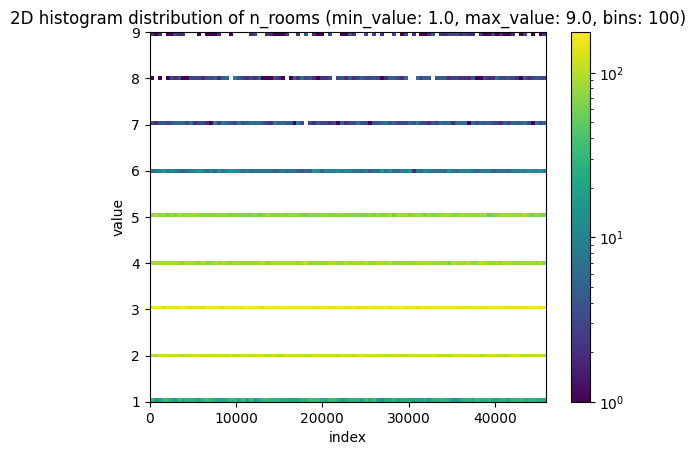

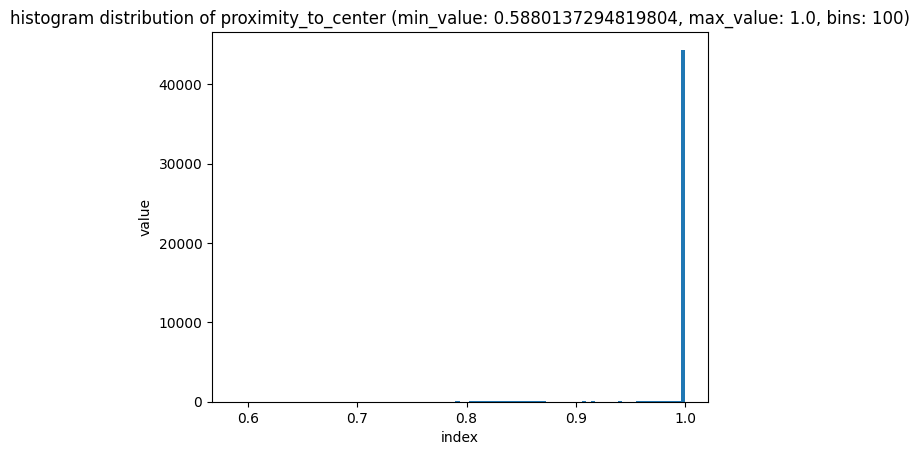

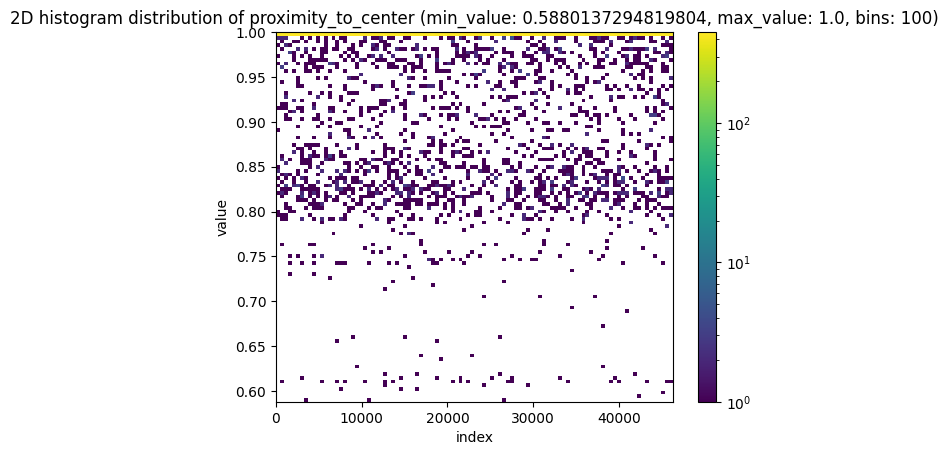

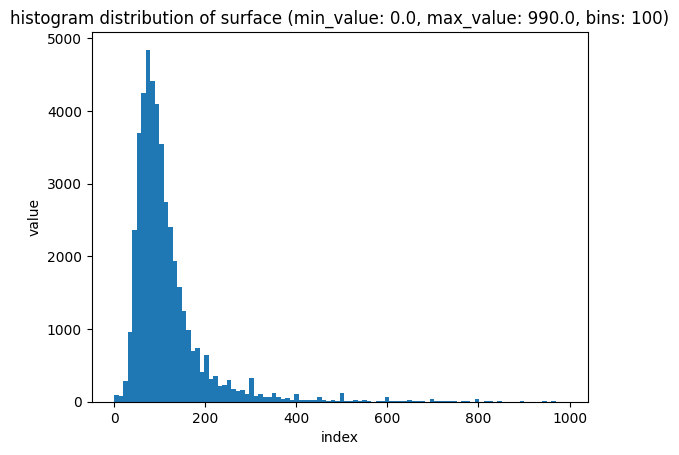

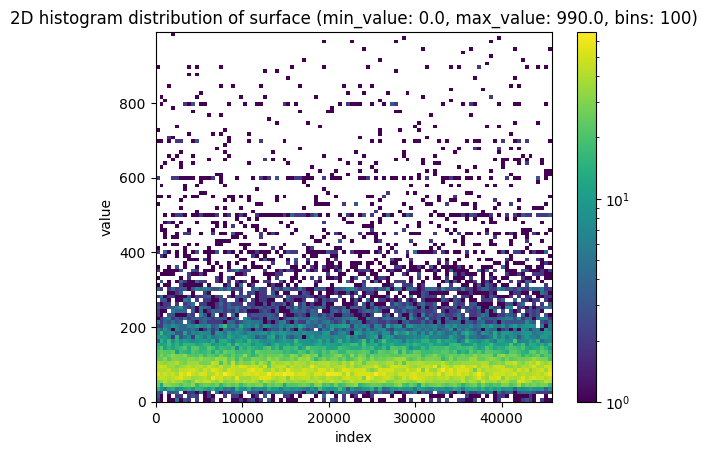

In [19]:
for col in columns_wnan:
    get_hist(train_df, col)

In [20]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)

In [21]:
analysis1, analysis2 = NaN_analysis(train_df)

In [22]:
analysis1

,column,n_nan,percentage
0,id,0,0.0
1,floor,0,0.0
2,proximity_to_center,0,0.0
3,n_rooms,0,0.0
4,total_floors,0,0.0
5,elevator,0,0.0
6,n_bathrooms,0,0.0
7,garden,0,0.0
8,expenses,0,0.0
9,price,0,0.0


In [23]:
analysis2

,n_nan,n_rows
0,17,0
1,16,0
2,15,0
3,14,0
4,13,0
5,12,0
6,11,0
7,10,0
8,9,0
9,8,0


In [24]:
train_df

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461.0,60000.0,1.0,0.0,1980.0,41.901300,12.700000,175.000,30.0,2.0,0.0,1.0,1.0,3.0,1.0,1.00000,35.0
1,51304.0,900000.0,0.0,0.0,1856.0,41.907017,12.481311,161.676,227.6,3.0,0.0,1.0,1.0,4.4,3.0,1.00000,131.0
2,33032.0,33000.0,0.0,0.0,1960.0,41.976500,12.440500,204.200,30.0,4.0,0.0,1.0,1.0,4.0,1.0,1.00000,16.0
3,62281.0,166000.0,0.0,1.0,1979.0,45.484800,12.198200,175.000,65.2,1.0,1.0,1.0,0.8,1.0,2.0,0.99205,100.0
4,45681.0,410000.0,1.0,0.0,1830.8,45.424480,12.328622,65.910,87.6,3.0,0.0,2.0,1.0,4.2,3.0,1.00000,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085.0,329999.0,1.0,0.0,1929.0,41.923500,12.446100,175.000,35.0,3.0,0.0,1.0,1.0,4.0,3.0,1.00000,88.0
46308,17403.0,599000.0,1.0,2.0,1920.0,41.916743,12.454925,166.200,170.0,6.0,0.0,2.0,1.0,4.2,5.0,1.00000,189.0
46309,33332.0,549000.0,1.0,0.0,1975.2,45.454701,9.242711,139.902,235.4,2.6,0.0,2.0,1.0,8.6,3.0,1.00000,140.0
46310,63367.0,189000.0,1.0,0.0,1965.0,45.445605,9.245942,163.348,150.0,-1.0,1.0,1.0,1.0,4.8,3.0,1.00000,70.0


# 2. Dataset analysis

- plottare le distribuzioni
- rimuovere gli outliers (questo solo sul train set)

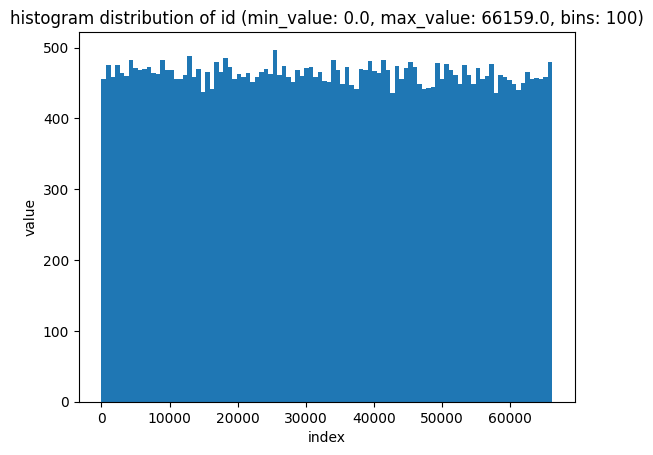

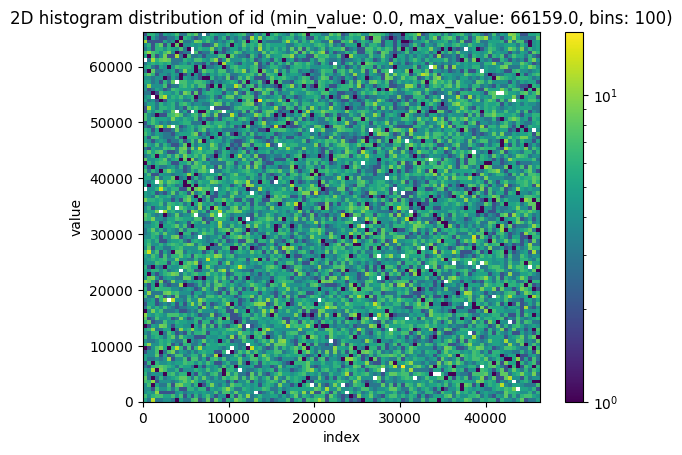

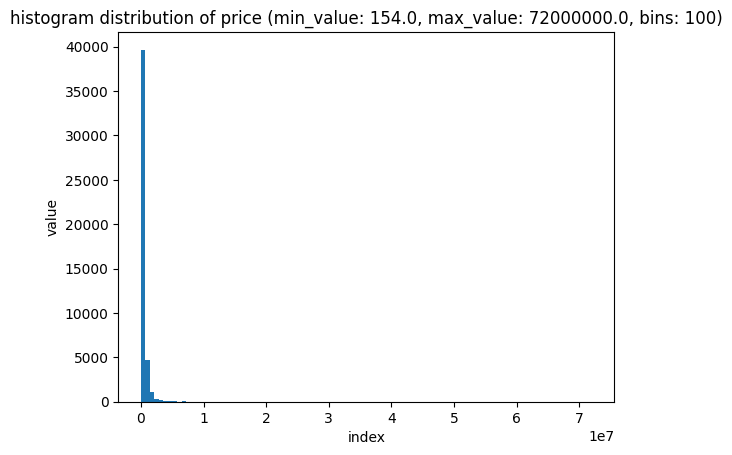

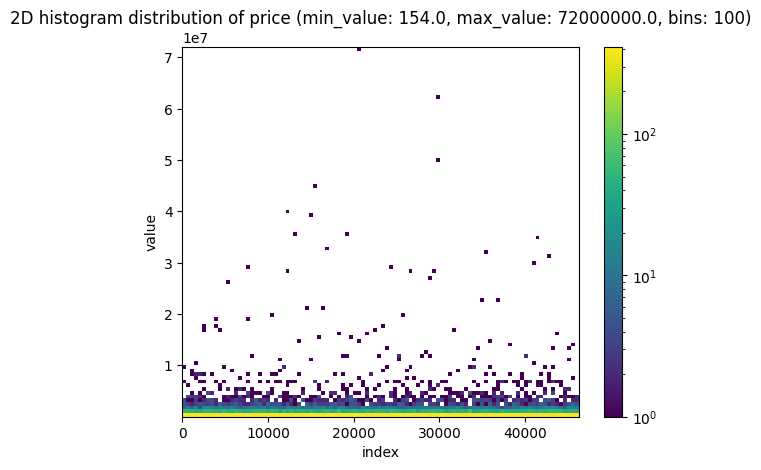

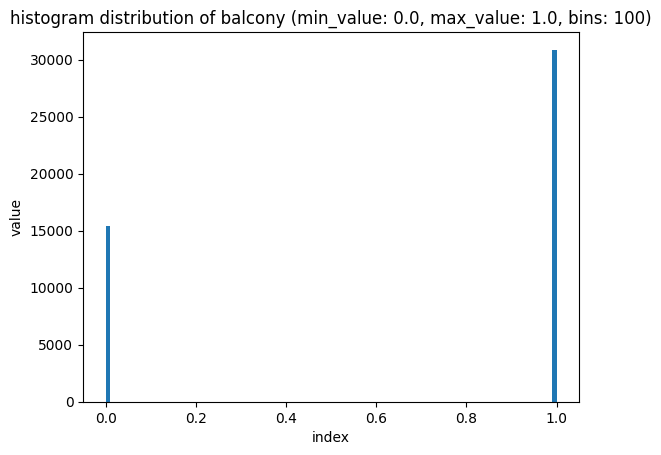

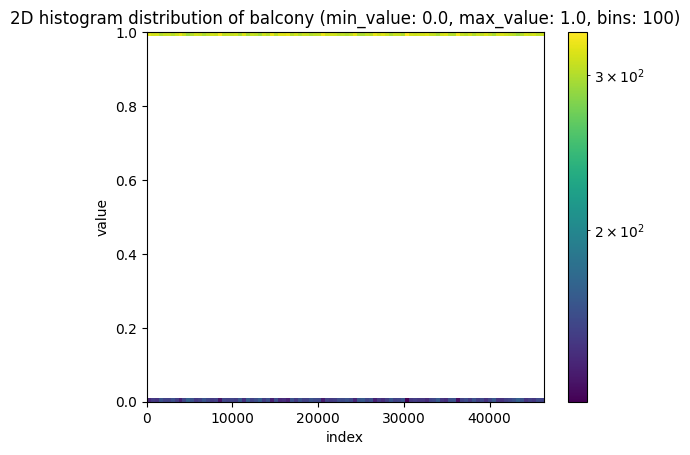

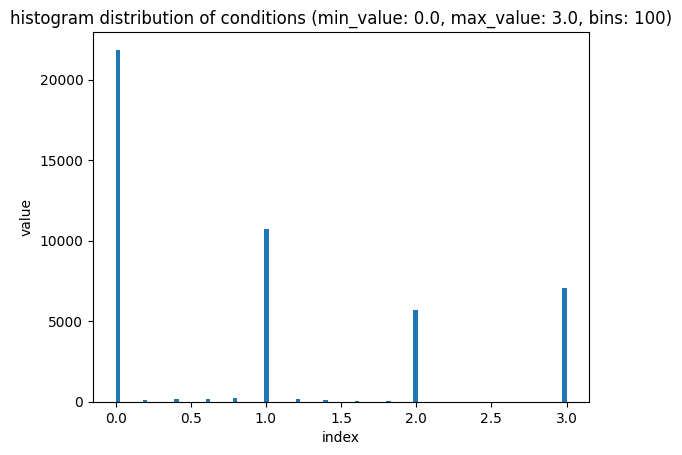

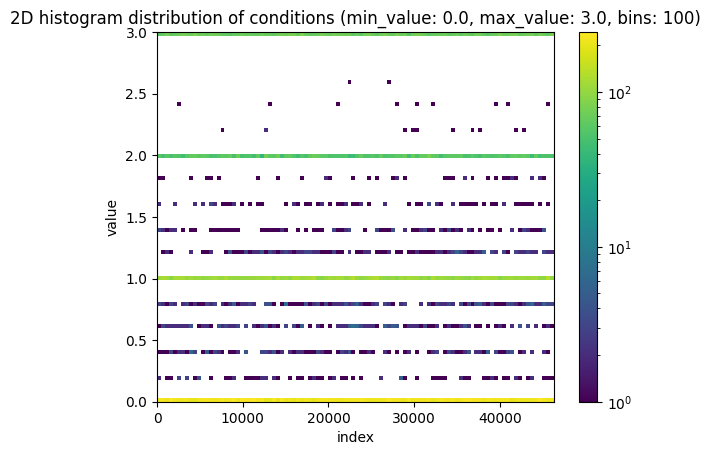

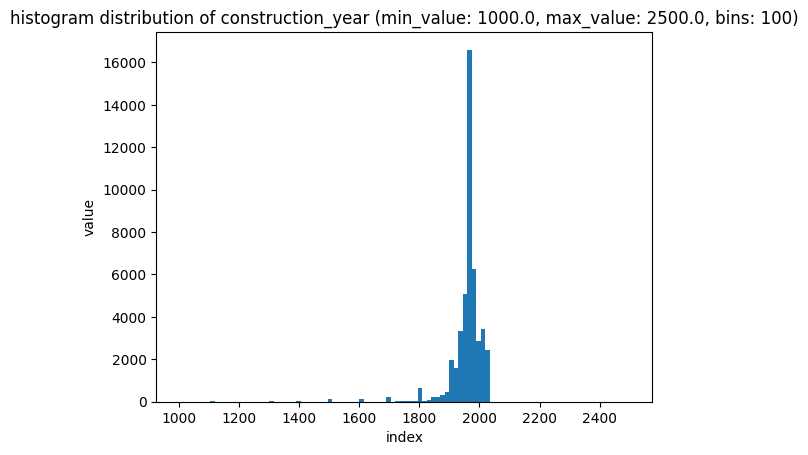

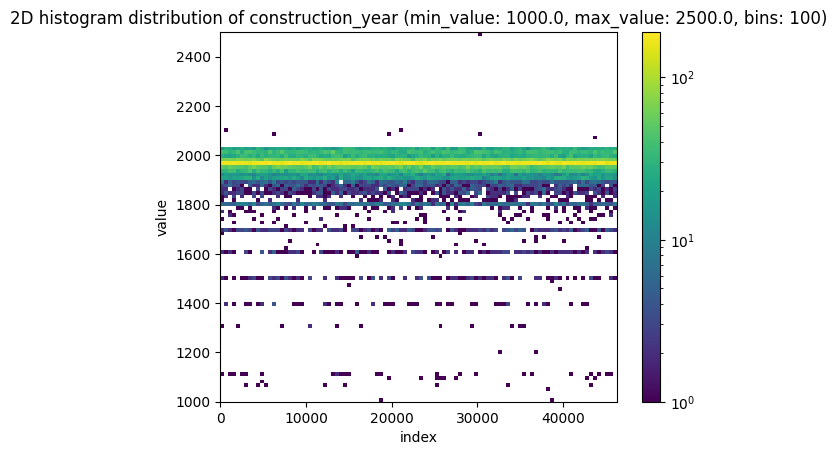

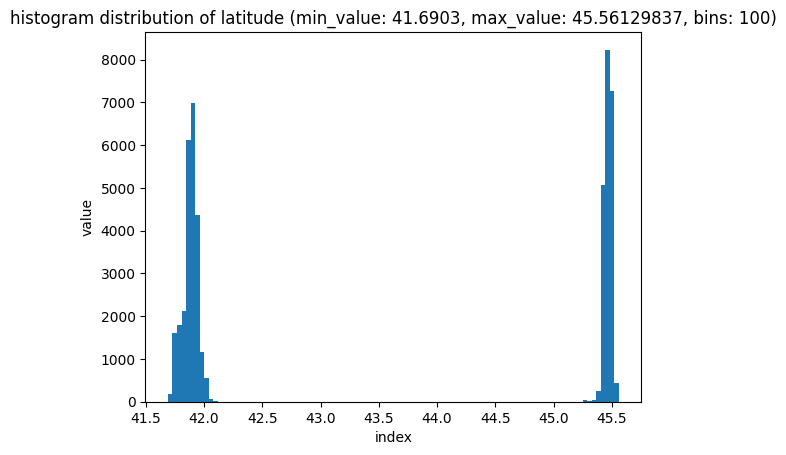

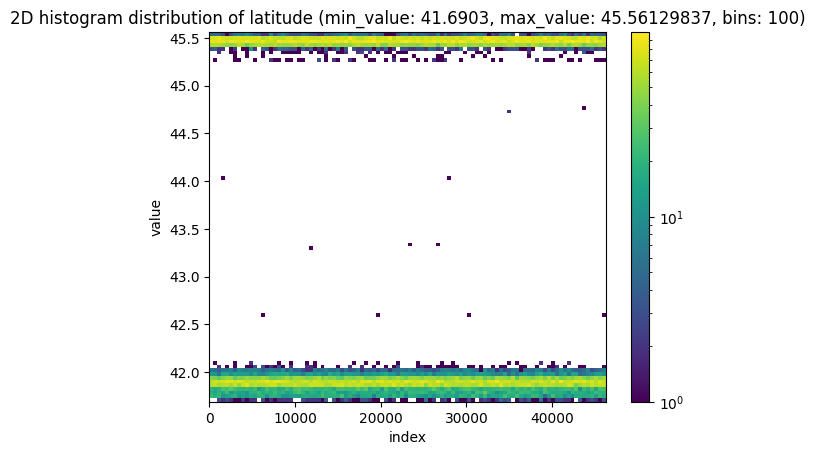

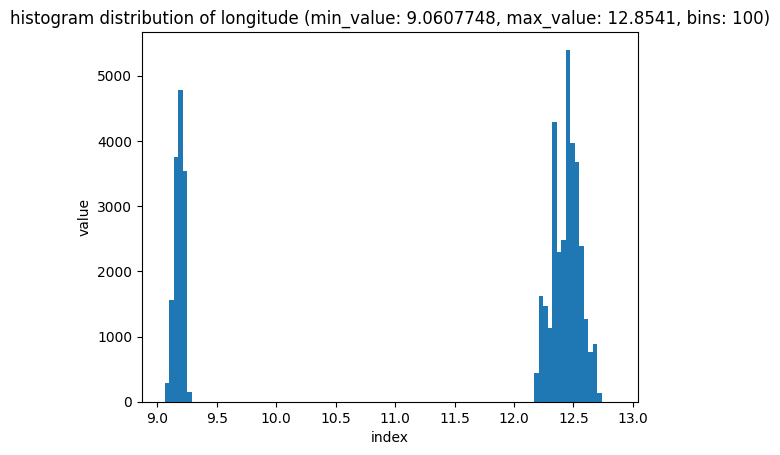

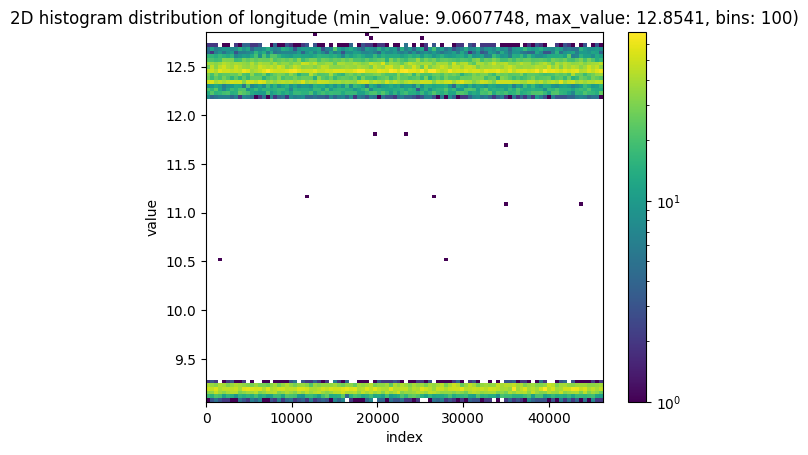

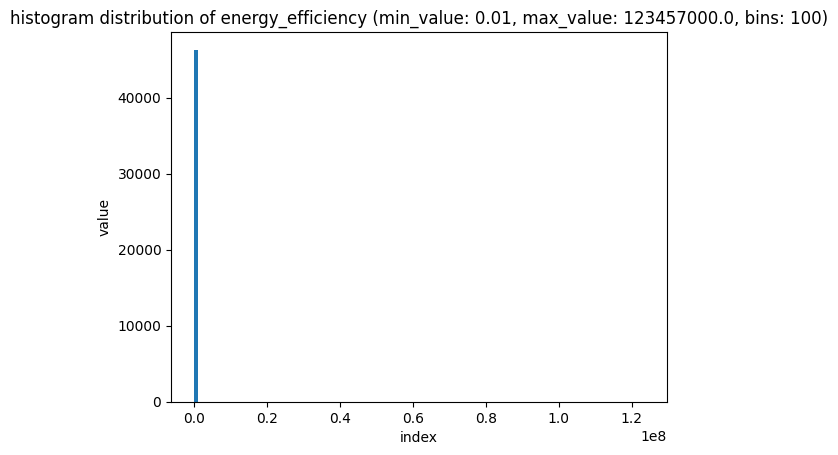

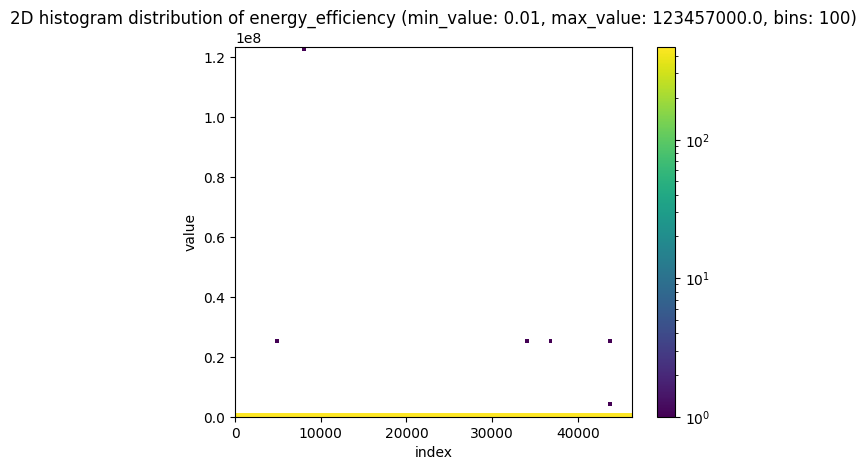

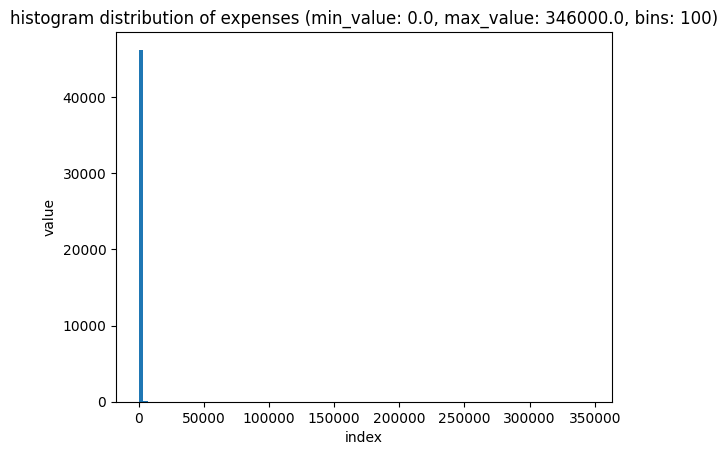

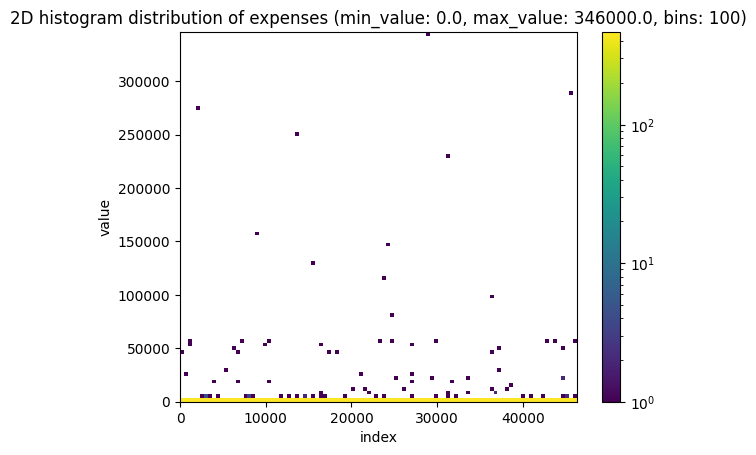

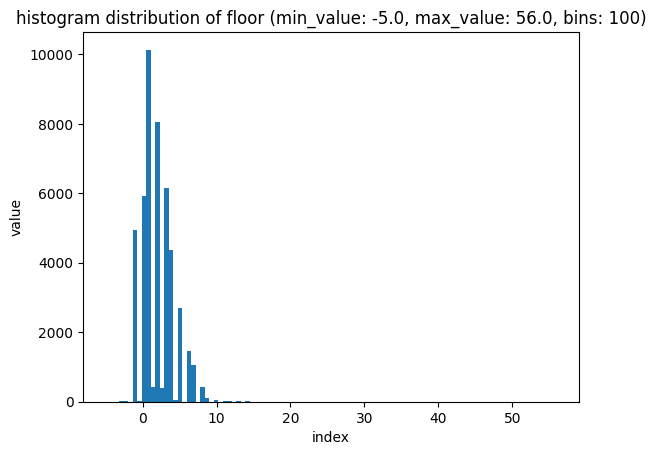

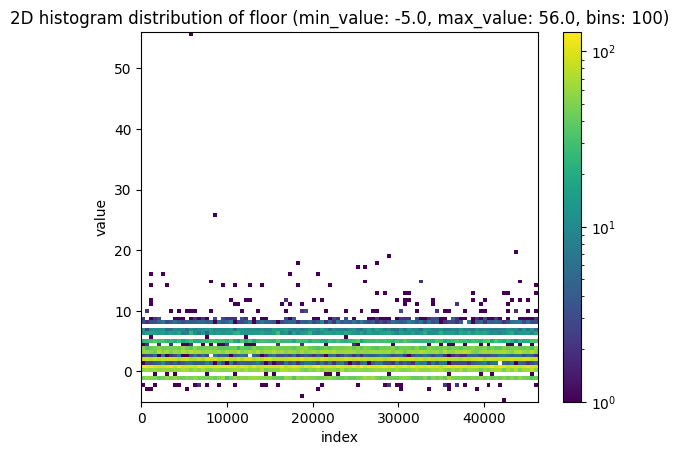

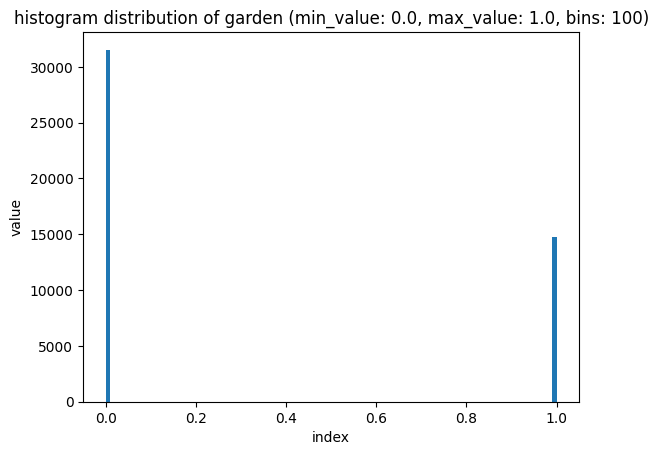

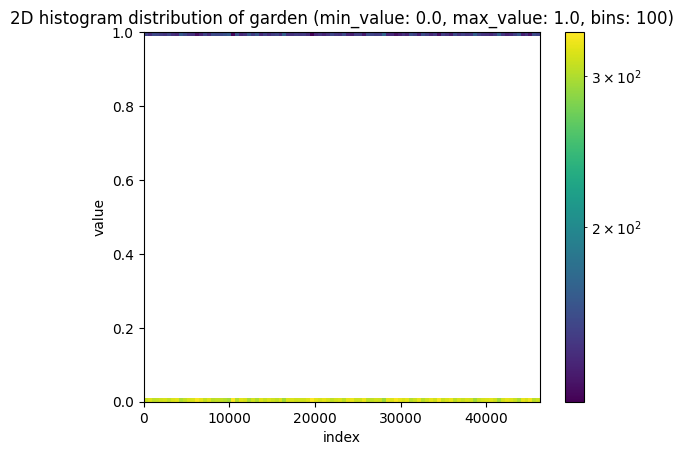

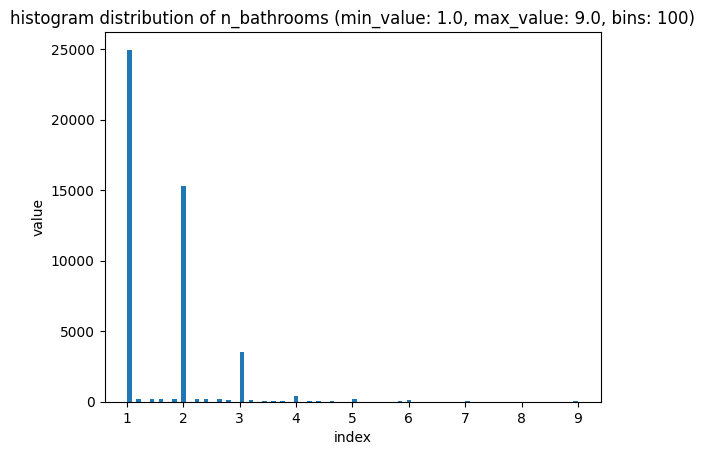

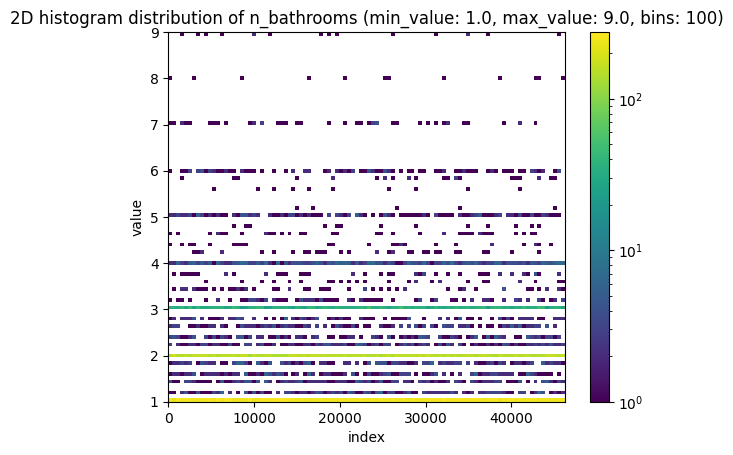

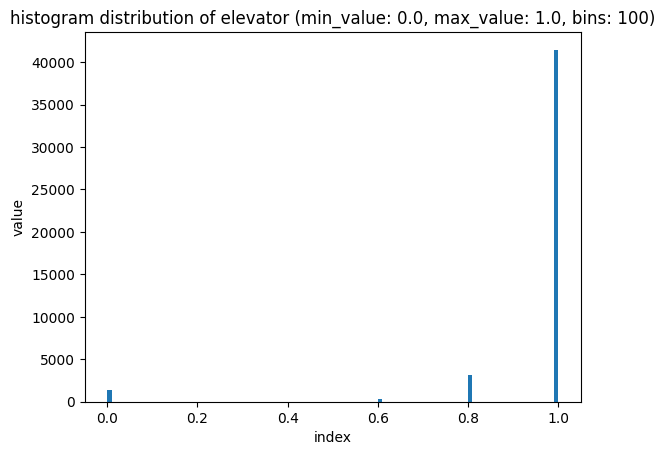

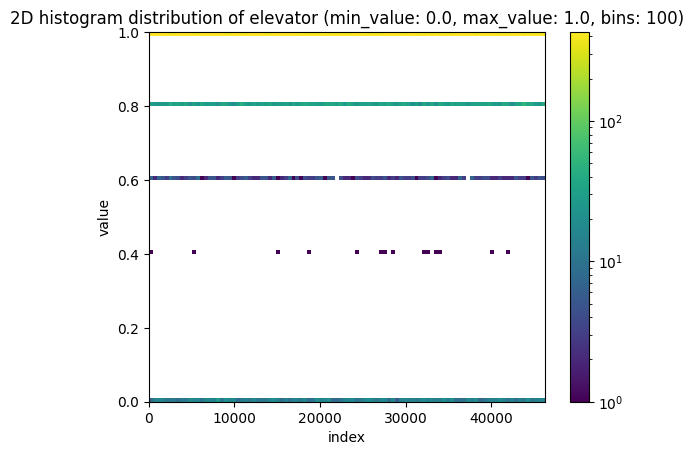

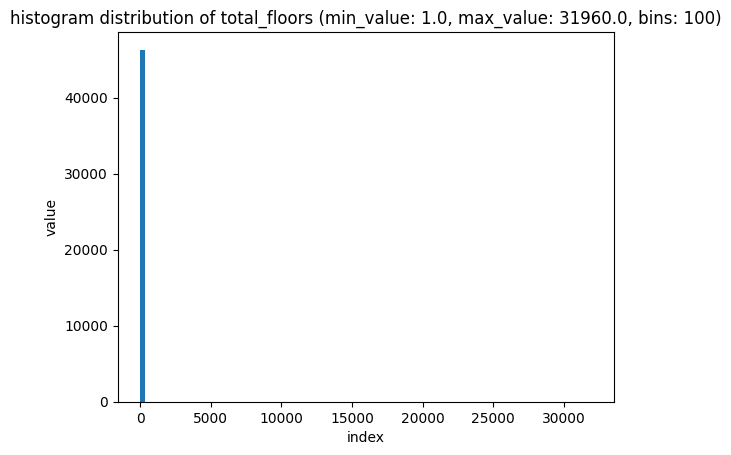

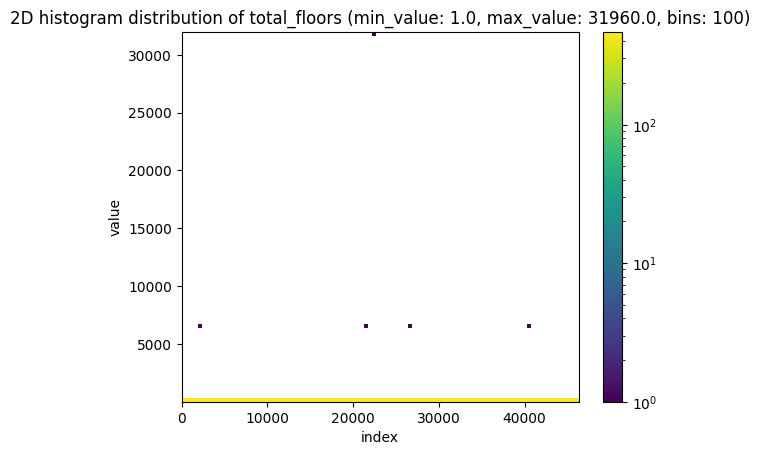

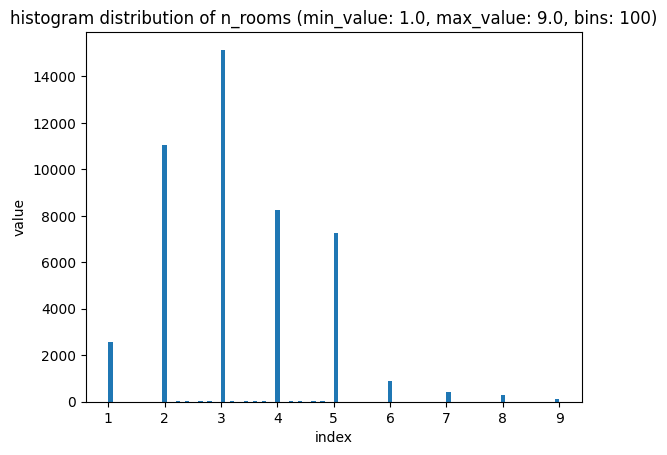

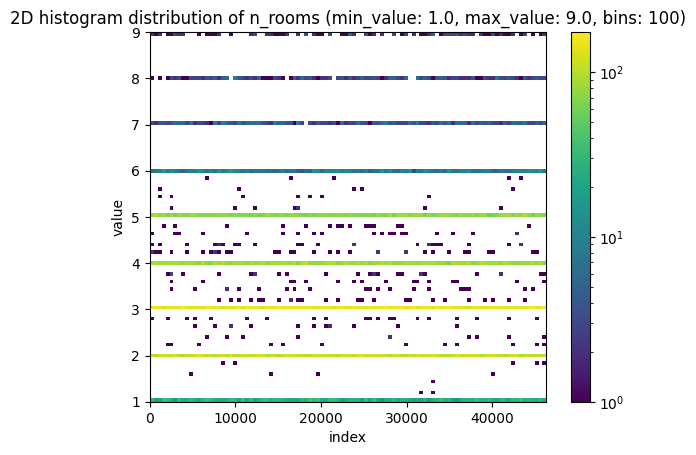

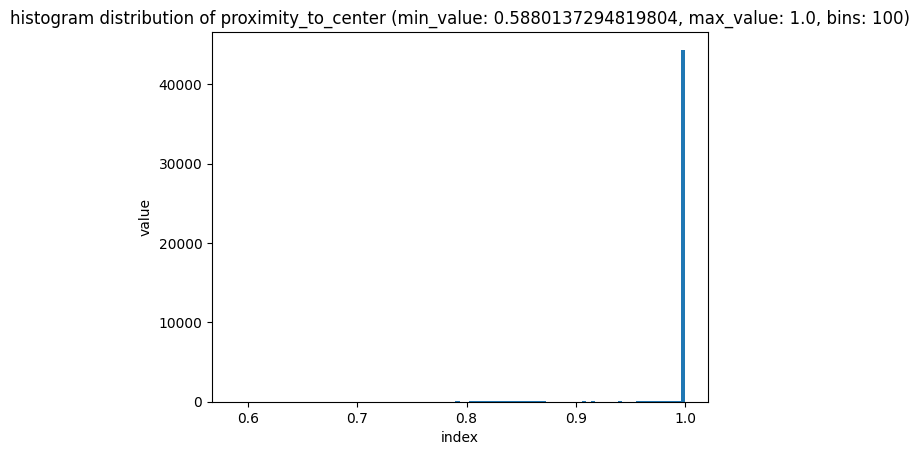

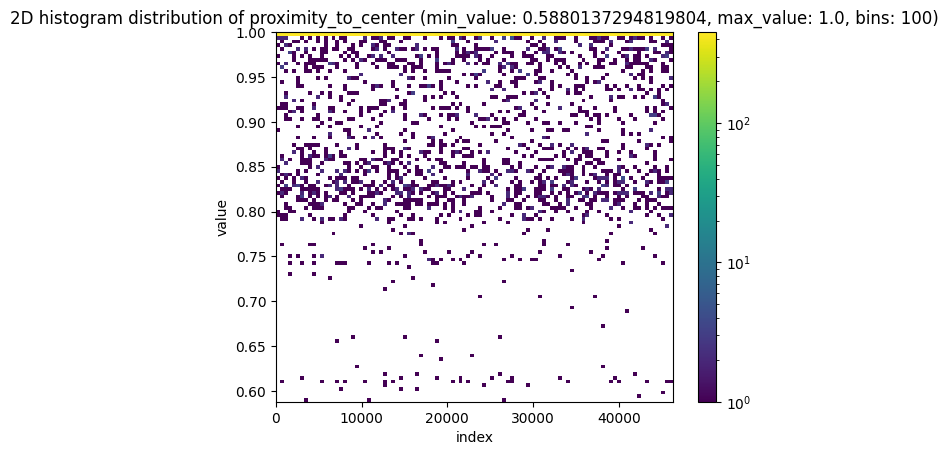

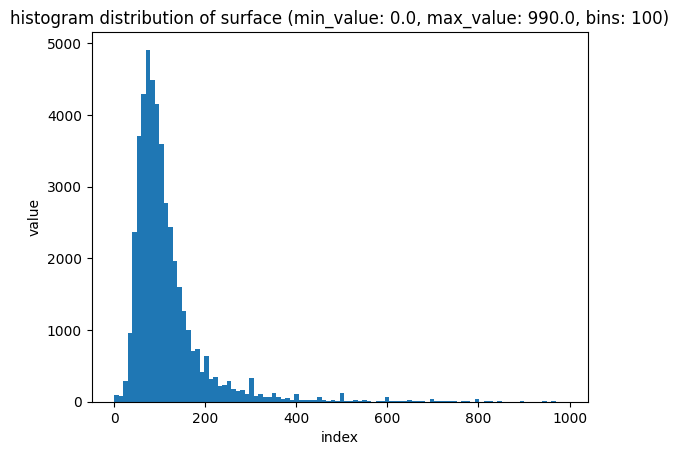

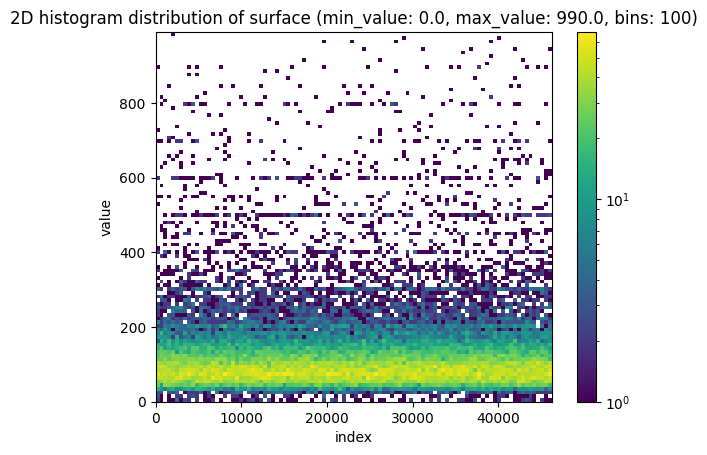

In [25]:
for col in train_df.columns:
    get_hist(train_df, col)

In [26]:
train_df

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461.0,60000.0,1.0,0.0,1980.0,41.901300,12.700000,175.000,30.0,2.0,0.0,1.0,1.0,3.0,1.0,1.00000,35.0
1,51304.0,900000.0,0.0,0.0,1856.0,41.907017,12.481311,161.676,227.6,3.0,0.0,1.0,1.0,4.4,3.0,1.00000,131.0
2,33032.0,33000.0,0.0,0.0,1960.0,41.976500,12.440500,204.200,30.0,4.0,0.0,1.0,1.0,4.0,1.0,1.00000,16.0
3,62281.0,166000.0,0.0,1.0,1979.0,45.484800,12.198200,175.000,65.2,1.0,1.0,1.0,0.8,1.0,2.0,0.99205,100.0
4,45681.0,410000.0,1.0,0.0,1830.8,45.424480,12.328622,65.910,87.6,3.0,0.0,2.0,1.0,4.2,3.0,1.00000,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46307,33085.0,329999.0,1.0,0.0,1929.0,41.923500,12.446100,175.000,35.0,3.0,0.0,1.0,1.0,4.0,3.0,1.00000,88.0
46308,17403.0,599000.0,1.0,2.0,1920.0,41.916743,12.454925,166.200,170.0,6.0,0.0,2.0,1.0,4.2,5.0,1.00000,189.0
46309,33332.0,549000.0,1.0,0.0,1975.2,45.454701,9.242711,139.902,235.4,2.6,0.0,2.0,1.0,8.6,3.0,1.00000,140.0
46310,63367.0,189000.0,1.0,0.0,1965.0,45.445605,9.245942,163.348,150.0,-1.0,1.0,1.0,1.0,4.8,3.0,1.00000,70.0


In [27]:
def boxplot(df, feature):
    plt.boxplot(df.loc[:, feature])
    plt.title('boxplot of {}'.format(feature))
    plt.ylabel('value')
    plt.show()
    plt.close()
    return

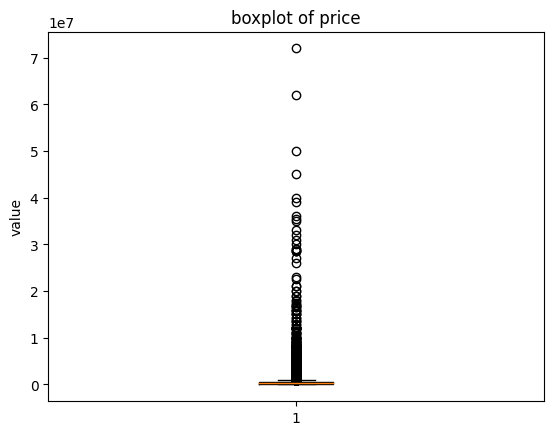

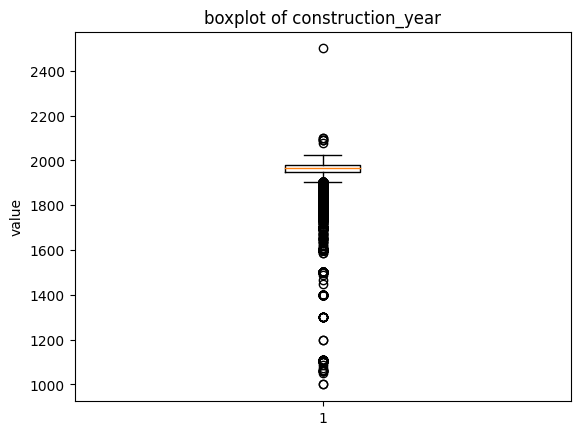

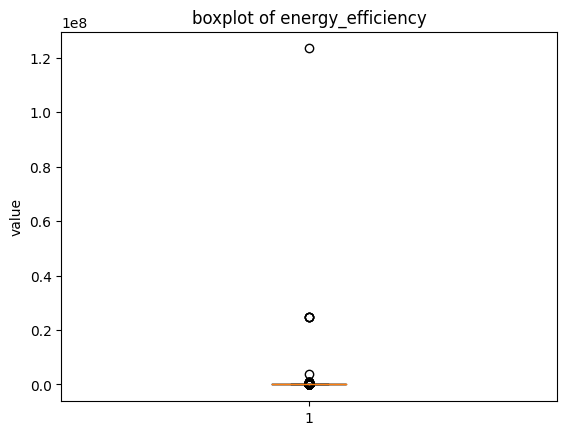

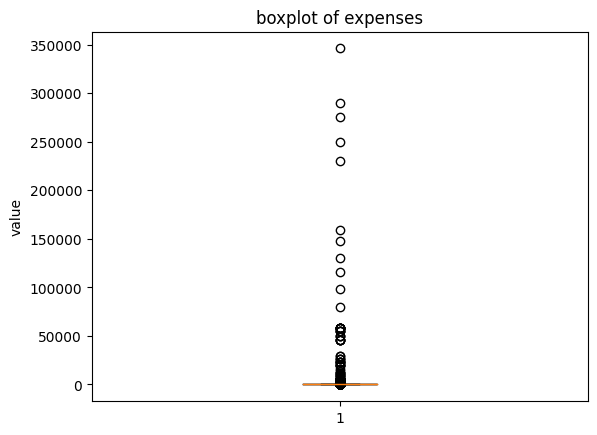

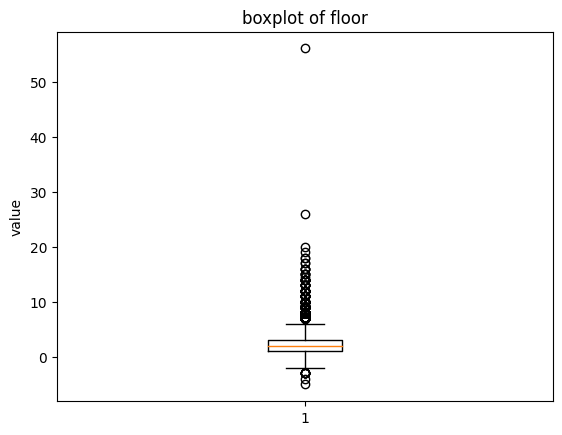

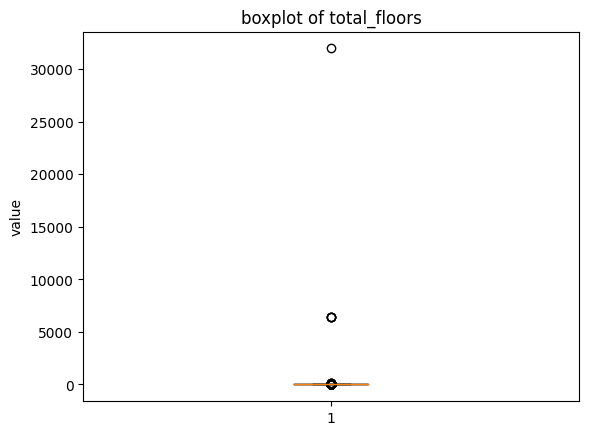

In [28]:
subcols = ['price', 'construction_year', 'energy_efficiency', 'expenses', 'floor', 'total_floors']
for col in subcols:
    boxplot(train_df, col)

In [59]:
original_shape = train_df.shape[0]
z_scores = zscore(train_df[subcols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 0.25).all(axis=1)

In [65]:
# series of indexes to remove
index_to_remove = train_df[subcols][filtered_entries].reset_index()['index']

In [66]:
train_df = train_df.drop(index_to_remove, axis=0).reset_index(drop=True)

In [68]:
new_shape = train_df.shape[0]

In [69]:
print('original shape: {}'.format(original_shape))
print('new shape: {}'.format(new_shape))
print('percentage of rows removed: {}%'.format(((original_shape-new_shape)*100)/original_shape))

original shape: 46312
new shape: 44417
percentage of rows removed: 4.091812057350147%


# 3. Feature importance analysis

- droppiamo le eventuali features che sono poco importanti per l'apprendimento 

In [71]:
train_df

,id,price,balcony,conditions,construction_year,latitude,longitude,energy_efficiency,expenses,floor,garden,n_bathrooms,elevator,total_floors,n_rooms,proximity_to_center,surface
0,10461.0,60000.0,1.0,0.0,1980.0,41.901300,12.700000,175.000,30.0,2.0,0.0,1.0,1.0,3.0,1.0,1.00000,35.0
1,51304.0,900000.0,0.0,0.0,1856.0,41.907017,12.481311,161.676,227.6,3.0,0.0,1.0,1.0,4.4,3.0,1.00000,131.0
2,33032.0,33000.0,0.0,0.0,1960.0,41.976500,12.440500,204.200,30.0,4.0,0.0,1.0,1.0,4.0,1.0,1.00000,16.0
3,62281.0,166000.0,0.0,1.0,1979.0,45.484800,12.198200,175.000,65.2,1.0,1.0,1.0,0.8,1.0,2.0,0.99205,100.0
4,45681.0,410000.0,1.0,0.0,1830.8,45.424480,12.328622,65.910,87.6,3.0,0.0,2.0,1.0,4.2,3.0,1.00000,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44412,33085.0,329999.0,1.0,0.0,1929.0,41.923500,12.446100,175.000,35.0,3.0,0.0,1.0,1.0,4.0,3.0,1.00000,88.0
44413,17403.0,599000.0,1.0,2.0,1920.0,41.916743,12.454925,166.200,170.0,6.0,0.0,2.0,1.0,4.2,5.0,1.00000,189.0
44414,33332.0,549000.0,1.0,0.0,1975.2,45.454701,9.242711,139.902,235.4,2.6,0.0,2.0,1.0,8.6,3.0,1.00000,140.0
44415,63367.0,189000.0,1.0,0.0,1965.0,45.445605,9.245942,163.348,150.0,-1.0,1.0,1.0,1.0,4.8,3.0,1.00000,70.0


In [72]:
# create x, y
df = train_df.drop('id', axis=1)
x = df.drop('price', axis=1)
y = df.price

In [74]:
from sklearn.ensemble import RandomForestRegressor

# compute feature_importances
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(x, y)
rf.feature_importances_

array([0.00420132, 0.01355932, 0.04530843, 0.02875492, 0.02734764,
       0.02635108, 0.35821832, 0.02655801, 0.00460247, 0.28876344,
       0.00122627, 0.0564671 , 0.0058253 , 0.00215998, 0.1106564 ])

<BarContainer object of 15 artists>

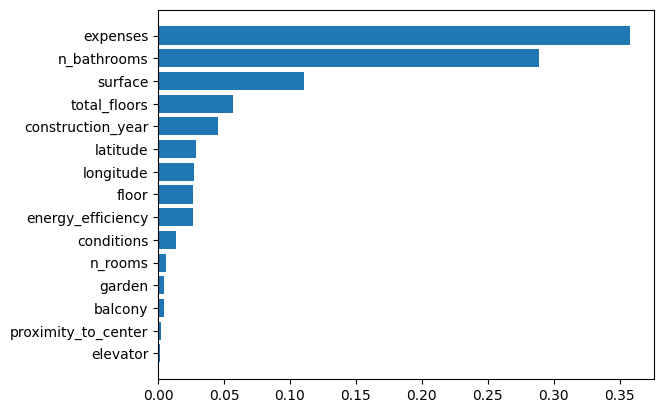

In [75]:
# plot feature_importances
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rf.feature_importances_[sorted_idx])

# 4. Add Features

In [85]:
analysis1, analysis2 = NaN_analysis(poi_df)

In [86]:
analysis1

,column,n_nan,percentage
0,tags.alt_name:gl,397381,99.999748
1,tags.source:name:oc,397381,99.999748
2,tags.name:east2276,397381,99.999748
3,tags.name:za,397381,99.999748
4,tags.ref:ISTAT,397380,99.999497
...,...,...,...
91,tags.addr:housenumber,292834,73.690806
92,lon,0,0.000000
93,source,0,0.000000
94,lat,0,0.000000


In [87]:
analysis2

,n_nan,n_rows
0,96,0
1,95,0
2,94,0
3,93,0
4,92,106013
...,...,...
91,5,0
92,4,0
93,3,0
94,2,0


In [88]:
poi_df = poi_df[['lat', 'lon']]

In [91]:
def get_poi_score(lat, lon, poi_df, n_poi=10):
    # lat -1 <= poi_df['lat'] >= lat + 1
    # lon -1 <= poi_df['lon'] >= lon + 1
    query = (poi_df['lat'] >= lat - 0.01) & (poi_df['lat'] <= lat + 0.01) & (poi_df['lon'] >= lon - 0.01) & (poi_df['lon'] <= lon + 0.01)
    tmp_df = poi_df[query].reset_index(drop=True)
    if tmp_df.shape[0] < n_poi:
        tmp_df = poi_df.copy()
    series = tmp_df.apply(lambda x: geopy.distance.distance((lat, lon), (x['lat'], x['lon'])).km, axis=1)


In [92]:
lat, lon = train_df.iloc[0].latitude, train_df.iloc[0].longitude
lat = 52.406374
lon = 16.9251681
series = poi_df.apply(lambda x: geopy.distance.distance((lat, lon), (x['lat'], x['lon'])).km, axis=1)

In [90]:
series

0          956.837889
1          956.774041
2          956.539642
3          956.811953
4          955.720152
             ...     
397377    1040.920807
397378    1043.427509
397379    1043.483300
397380    1042.919221
397381    1043.300466
Length: 397382, dtype: float64

In [ ]:
lat, lon = train_df.iloc[0].latitude, train_df.iloc[0].longitude
lat = 52.406374
lon = 16.9251681
series = poi_df.apply(lambda x: geopy.distance.distance((lat, lon), (x['lat'], x['lon'])).km, axis=1)
series[series < 20]
series[series < 400]
def compute_distance_km(lat1, lon1, lat2, lon2):
    return geopy.distance.distance((lat1, lon1), (lat2, lon2)).km
lat1, lon1 = 1, 1
lat2, lon2 = 1, 1
compute_distance_km(lat1, lon1, lat2, lon2)
def foo(lat, lon, poi_df):
    series = poi_df.apply(lambda x: geopy.distance.distance((lat, lon), (x['lat'], x['lon'])).km, axis=1)
    series.sort_values()
    return
train_df['poi'] = train_df[['lat', 'lon']].apply(lambda x: foo(x['lat'], x['lon'], poi_df)) 

# 5. Add Samples (Oversampling)

- nel caso di regression non serve undersampling
- quindi facciamo oversampling aumentando i samples sinteticamente con funzioni apposite (SMOTE)
- oppure tramite integrazione di nuovi samples non sintetici da internet

# 5. Training

- creare tutti i regressor possibili e trainarli

# 6. Testing (evaluation)
- performiamo i modelli trainati sul test set e quindi misuriamo le performance (MSE)

# 7. Tuning

- troviamo la combinazione di iperparametri migliori per il modello migliore che abbiamo fino ad ora ottenuto
- quindi accordiamo il modello migliore